In [66]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from ucifetch.fetch import fetch_ucirepo, list_available_datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import random as rand
from statistics import mode

In [134]:
#Importing Iris dataset as Pandas dataframe.
iris_dataset = fetch_ucirepo(id=53) 

iris_X = iris_dataset.data.features 
iris_Y = iris_dataset.data.targets 

class_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

iris_Y['class'] = iris_Y['class'].map(class_mapping)

#Importing Breast Cancer dataset as Pandas dataframe.
breast_cancer = fetch_ucirepo(id=15)

breast_cancer_X = breast_cancer.data.features.drop(columns=["Bare_nuclei"], axis=1)
breast_cancer_Y = breast_cancer.data.targets
class_mapping = {2: 0, 4: 1}

breast_cancer_Y['Class'] = breast_cancer_Y['Class'].map(class_mapping)

#Importing Haberman's Survival dataset as Pandas dataframe.
survival=pd.read_csv("data\\haberman\\haberman_features.data")

survival_X = survival.drop('Class', axis=1).drop('Year', axis=1)
survival_Y= survival.loc[:,'Class'].to_frame()
class_mapping = {1: 0, 2: 1}
survival_Y['Class'] = survival_Y['Class'].map(class_mapping)

#Importing Image Segmentation dataset as Pandas dataframe, doing a bit of preprocessing.
image_segmentation_train=pd.read_csv("data\\image_segmentation\\segmentation_train.data")
image_segmentation_test=pd.read_csv("data\\image_segmentation\\segmentation_test.test")
image_segmentation_train=image_segmentation_train.reset_index()
image_segmentation_test=image_segmentation_test.reset_index()

image_segmentation_train_Y=image_segmentation_train.loc[:, 'index'].to_frame()
image_segmentation_train_Y=image_segmentation_train_Y.rename(columns={'index':'class'})
image_segmentation_train_X=image_segmentation_train.drop('index', axis=1)

image_segmentation_test_Y=image_segmentation_test.loc[:, 'index'].to_frame()
image_segmentation_test_Y=image_segmentation_test_Y.rename(columns={'index':'class'})
image_segmentation_test_X=image_segmentation_test.drop('index', axis=1)

class_mapping = {'BRICKFACE': 0, 'SKY': 1, 'FOLIAGE':2, 'CEMENT':3, 'WINDOW':4, 'PATH':5, 'GRASS':6}
image_segmentation_train_Y['class'] = image_segmentation_train_Y['class'].map(class_mapping)
image_segmentation_test_Y['class'] = image_segmentation_test_Y['class'].map(class_mapping)

C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_32516\4026239699.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_Y['class'] = iris_Y['class'].map(class_mapping)
C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_32516\4026239699.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer_Y['Class'] = breast_cancer_Y['Class'].map(class_mapping)


In [124]:
print(survival_X)

     Age  Nodes
0     30      1
1     30      3
2     30      0
3     31      2
4     31      4
..   ...    ...
301   75      1
302   76      0
303   77      3
304   78      1
305   83      2

[306 rows x 2 columns]


In [125]:
class BinningLayer(torch.nn.Module):
    def __init__(self, num_cutting_points, tau, feature_min, feature_max):
        super(BinningLayer, self).__init__()
        
        #Constant binner in the first softmax layer. Not trained
        self.w=torch.Tensor([i+1 for i in range(num_cutting_points+1)])
        
        #Cut points, randomized between the minimum and maximum values for each feature. Length n.
        cut_points=(feature_min + (feature_max - feature_min) * torch.rand(num_cutting_points)).numpy()
        cut_points.sort()
        
        bias_list=torch.Tensor([0]+[-cut_points[i] for i in range(len(cut_points))])
        for i in range(1, len(bias_list)):
            bias_list[i]+=bias_list[i-1]
        self.b = torch.nn.Parameter(bias_list)

        self.tau=tau #Temperature parameter for the first softmax layer.
        self.softmax=torch.nn.Softmax() #Classifier softmax layer.
        
    #Forward propogation.
    def forward(self, x):
        x=torch.add(torch.multiply(self.w, x), self.b)
        x=self.softmax(torch.div(x, self.tau))
        return x
    
class DNDT(torch.nn.Module):
    def __init__(self, X_frame, Y_frame, num_cutting_points=1, tau=0.01, feature_sample=False, num_samples=10):
        super(DNDT, self).__init__()

        self.X=X_frame #Features dataframe in pandas.
        self.Y=Y_frame #Targets dataframe in pandas.
        self.num_cutting_points=num_cutting_points #Number of cutting points for each feature.
        self.tau=tau #Temperature parameter for the first softmax layer.
        
        self.range_matrix=self.create_range_matrix() #Dx2 matrix, where each length 2 matrix is the min and
            #max of each feature in your dataset.
        self.binning_layers=self.create_binning_layers() #D matrix, where the i-entry is a NN model for
            #soft binning the i-th feature.
        self.num_features=self.X.shape[1] #D
        self.num_classes=max(self.Y[self.Y.columns[0]])+1 #C
        self.sample=range(self.num_features) #All features to pick, is all of them if we're not sampling.

        if feature_sample:
            self.sample=self.create_sample(num_samples)
            self.num_features=num_samples

        self.linear_layer=torch.nn.Linear((self.num_cutting_points+1)**(self.num_features), 
                                          self.num_classes) #Linear classifier layer.
        self.softmax=torch.nn.Softmax() #Classifier softmax layer.

    def create_sample(self, num_samples):
        return rand.sample(range(self.num_features), num_samples)
    #Creates binning layers list.
    def create_binning_layers(self):
        res=[None]*self.X.shape[1]
        for i in range(len(res)):
            res[i]=BinningLayer(self.num_cutting_points, self.tau, self.range_matrix[i][0], self.range_matrix[i][1])
        return res
    
    #Creates range matrix list.
    def create_range_matrix(self):
        res=[[0,0] for i in range(self.X.shape[1])]
        columns=self.X.columns
        i=0
        for column in columns:
            res[i][0]=min(self.X[column])
            res[i][1]=max(self.X[column])
            i+=1
        return res
            
    #Kronecker products all of the softly-binned layers.
    def kronecker_prod(self, x):
        result=x[0]
        for i in range(1, len(x)):
            result=torch.kron(result, x[i])
        return result
    
    #Forward propogation.
    def forward(self, x):
        x = torch.stack([self.binning_layers[i](x[i]) for i in self.sample], dim=0)
        x=self.kronecker_prod(x)
        x=self.linear_layer(x)
        return x
    

In [135]:
#Loading in our dataframes into Pytorch dataloaders.
X=survival_X
Y=survival_Y

X_test=image_segmentation_test_X
Y_test=image_segmentation_test_Y

X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y.values, dtype=torch.float32).squeeze()

X_tensor_test = torch.tensor(X_test.values, dtype=torch.float32)
Y_tensor_test = torch.tensor(Y_test.values, dtype=torch.float32).squeeze()

Y_tensor=torch.nn.functional.one_hot(Y_tensor.to(torch.int64))
Y_tensor_test=torch.nn.functional.one_hot(Y_tensor_test.to(torch.int64))

X_train, X_val, Y_train, Y_val = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = TensorDataset(X_val, Y_val)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

test_dataset= TensorDataset(X_tensor_test, Y_tensor_test)
test_loader= DataLoader(test_dataset, batch_size=1, shuffle=True)

C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_32516\2824970187.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(deep_decision_tree(inputs))


tensor([0.7735, 0.2265], grad_fn=<SoftmaxBackward0>)
tensor([[1, 0]])
tensor([0.6920, 0.3080], grad_fn=<SoftmaxBackward0>)
tensor([[1, 0]])
tensor([0.7676, 0.2324], grad_fn=<SoftmaxBackward0>)
tensor([[1, 0]])
tensor([0.7676, 0.2324], grad_fn=<SoftmaxBackward0>)
tensor([[1, 0]])
tensor([0.8370, 0.1630], grad_fn=<SoftmaxBackward0>)
tensor([[1, 0]])
tensor([0.6155, 0.3845], grad_fn=<SoftmaxBackward0>)
tensor([[0, 1]])
tensor([0.5729, 0.4271], grad_fn=<SoftmaxBackward0>)
tensor([[1, 0]])
tensor([0.6891, 0.3109], grad_fn=<SoftmaxBackward0>)
tensor([[0, 1]])
tensor([0.8370, 0.1630], grad_fn=<SoftmaxBackward0>)
tensor([[1, 0]])
tensor([0.8370, 0.1630], grad_fn=<SoftmaxBackward0>)
tensor([[0, 1]])
tensor([0.8009, 0.1991], grad_fn=<SoftmaxBackward0>)
tensor([[1, 0]])
tensor([0.6891, 0.3109], grad_fn=<SoftmaxBackward0>)
tensor([[0, 1]])
tensor([0.8009, 0.1991], grad_fn=<SoftmaxBackward0>)
tensor([[0, 1]])
tensor([0.7591, 0.2409], grad_fn=<SoftmaxBackward0>)
tensor([[1, 0]])
tensor([0.7276, 0.27

Text(0.5, 1.0, 'Accuracy vs Num Epochs')

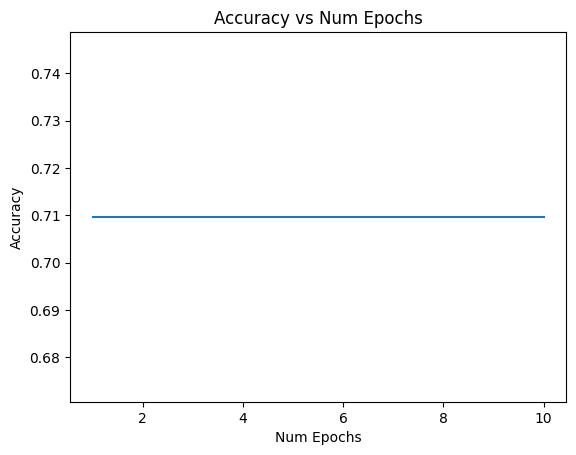

In [147]:
#Training single trees.
accuracies=[]
epoch_range=range(1,11)
for j in epoch_range:   
    loss_function = torch.nn.CrossEntropyLoss()
    deep_decision_tree=DNDT(X, Y, num_cutting_points=5, tau=0.01, feature_sample=False)
    optimizer = torch.optim.Adam(deep_decision_tree.parameters(), lr=0.001)
    for epoch in range(j):
        for batch in train_loader:
            inputs, labels=batch[0][0], batch[1]
            optimizer.zero_grad()
            outputs = deep_decision_tree(inputs)
            loss = loss_function(outputs, labels[0].to(torch.float32))
            loss.backward()
            optimizer.step()
            
            
    correct=0
    total=0     
    for batch in val_loader:
        inputs, labels=batch[0][0], batch[1]
        optimizer.zero_grad()
        outputs = torch.nn.functional.softmax(deep_decision_tree(inputs))
        if j==10:
            print(outputs)
            print(labels)
        if torch.argmax(outputs).item()==torch.argmax(labels[0]).item():
            correct+=1
        total+=1
        
    accuracies.append(correct/total)

plt.plot(epoch_range, accuracies)
plt.xlabel("Num Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Num Epochs")

In [137]:
print(accuracies)

[0.6935483870967742, 0.7096774193548387, 0.7258064516129032, 0.7096774193548387, 0.7096774193548387, 0.7096774193548387, 0.7096774193548387, 0.7096774193548387, 0.7096774193548387, 0.7096774193548387]


C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_32516\4198647278.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(tree(inputs))


Text(0.5, 1.0, 'Accuracy vs Num Epochs for Random Forest Selecting 10 Features')

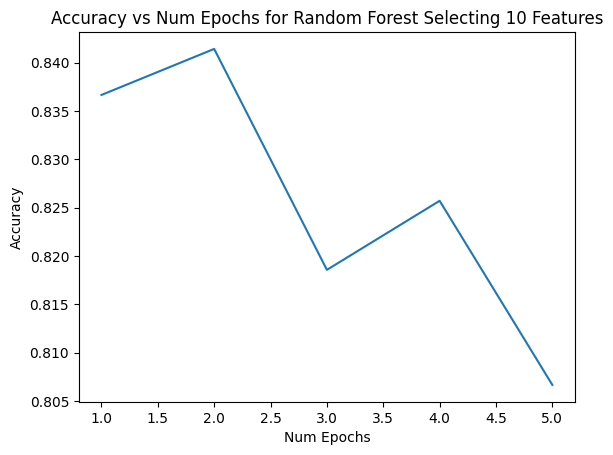

In [96]:
#Training decision forests.
accuracies=[]
num_trees=10
epoch_range=range(1,6)
for j in epoch_range:   
    loss_function = torch.nn.CrossEntropyLoss()
    decision_trees=[DNDT(X, Y, num_cutting_points=2, tau=0.01, feature_sample=True, num_samples=10) 
                    for i in range(num_trees)]
    for tree in decision_trees:
        optimizer = torch.optim.Adam(tree.parameters(), lr=0.001)
        for epoch in range(j):
            for batch in train_loader:
                inputs, labels=batch[0][0], batch[1]
                optimizer.zero_grad()
                outputs = tree(inputs)
                loss = loss_function(outputs, labels[0].to(torch.float32))
                loss.backward()
                optimizer.step()
    correct=0
    total=0
    for batch in test_loader:
        predictions=[]
        inputs, labels=batch[0][0], batch[1]
        for tree in decision_trees:  
            outputs = torch.nn.functional.softmax(tree(inputs))
            predictions.append(torch.argmax(outputs).item())
        if mode(predictions)==torch.argmax(labels[0]).item():
            correct+=1
        total+=1
    accuracies.append(correct/total)
    
plt.plot(epoch_range, accuracies)
plt.xlabel("Num Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Num Epochs for Random Forest Selecting 10 Features")

In [97]:
print(accuracies)

[0.8366666666666667, 0.8414285714285714, 0.8185714285714286, 0.8257142857142857, 0.8066666666666666]
